In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier, XGBRegressor
import seaborn as sns
sns.set_style("dark")

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer

%pylab inline
data=None
def absolute_correlations(col, df=data):
    #absolute_values = np.abs(df[col])
    corrs = pd.DataFrame(df.select_dtypes(include=[np.number]).corrwith(df[col]), columns=['correlation'])
    corrs['absol'] = np.abs(corrs['correlation'])
    return corrs.sort_values('absol', ascending=False).drop('absol', axis=1).tail(len(corrs)-1)

Populating the interactive namespace from numpy and matplotlib


In [2]:
data = pd.read_csv('data_cleaned.csv')
del data['Unnamed: 0']

# Use only good data

# Users could enter any number for age, so let's remove the jokers
data = data[data['age'] < 71]

# Simplify genders down to two, for convenience
data = data[(data['gender'] < 3) & (data['gender'] > 0)]
lbl = LabelBinarizer()
data['gender'] = lbl.fit_transform(data['gender']).flatten()

# Those who found the results accurate
data = data[data.accuracy >= 90]

# 962 rows, 39 features
data.shape

(623, 39)

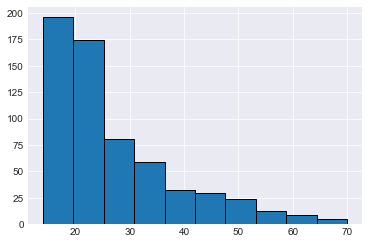

In [3]:
data['age'].hist(edgecolor='black')

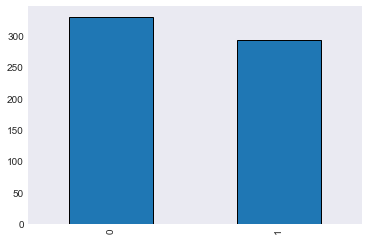

In [4]:
data['gender'].value_counts().plot.bar(edgecolor='black')

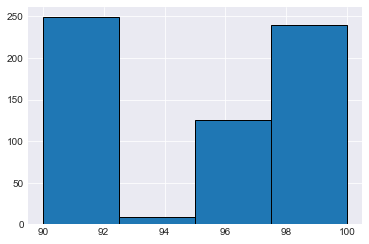

In [5]:
data['accuracy'].hist(edgecolor='black', bins=4)

# Male vs female humor

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

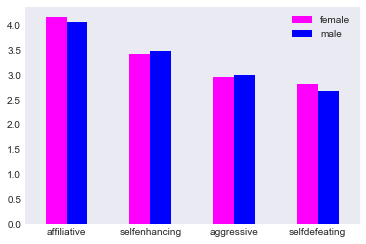

In [6]:
gender = data.groupby('gender').mean()
gender.index = ['female', 'male']

gender[['affiliative', 'selfenhancing',
        'aggressive', 'selfdefeating']].T.plot.bar(color=['magenta', 'blue'])

plt.xticks(rotation=0)

Men and women actually don't differ *that* much!

# Humor by age

## Men

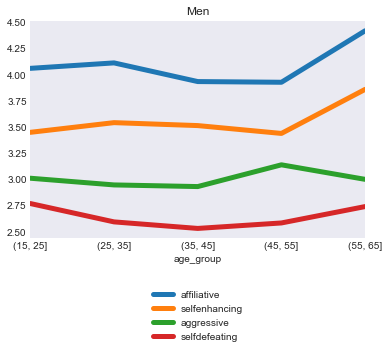

In [7]:
bins = np.arange(data.age.min()+1, data.age.max()+1, 10)
data['age_group'] = pd.Series(pd.cut(data['age'], bins=bins))

age = data[data['gender'] == 1].groupby('age_group').mean()

age[['affiliative', 'selfenhancing',
        'aggressive', 'selfdefeating']].plot(linewidth=5)

plt.title('Men')
pylab.legend(loc=9, bbox_to_anchor=(0.5, -.2))

Let's look at whether do in fact become more affiliative as they get older. We'll compare the lowest score to the highest score.

In [8]:
from scipy.stats import ttest_ind

men_age_50 = data[(data.gender == 1) & (data.age_group.astype(str) == '(45, 55]')]['affiliative'].dropna()
men_age_60 = data[(data.gender == 1) & (data.age_group.astype(str) == '(55, 65]')]['affiliative'].dropna()

ttest_ind(men_age_50, men_age_60)

Ttest_indResult(statistic=-1.3600006465338124, pvalue=0.1882524685652196)

The difference is not statistically significant!

Now let's look at women's scores...

## Women

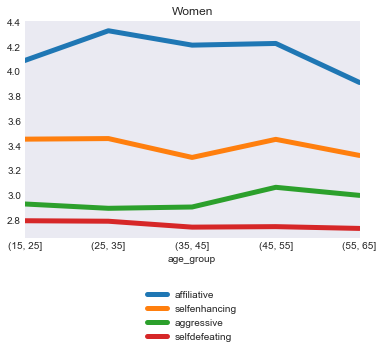

In [9]:
bins = np.arange(data.age.min()+1, data.age.max()+1, 10)
data['age_group'] = pd.Series(pd.cut(data['age'], bins=bins))

age = data[data['gender'] == 0].groupby('age_group').mean()

age[['affiliative', 'selfenhancing',
        'aggressive', 'selfdefeating']].plot(linewidth=5)

plt.title('Women')
pylab.legend(loc=9, bbox_to_anchor=(0.5, -.2))

Do women really become less affiliative?

In [10]:
from scipy.stats import ttest_ind

women_age_30 = data[(data.gender == 0) & (data.age_group.astype(str) == '(25, 35]')]['affiliative'].dropna()
women_age_60 = data[(data.gender == 0) & (data.age_group.astype(str) == '(55, 65]')]['affiliative'].dropna()

ttest_ind(women_age_30, women_age_60)

Ttest_indResult(statistic=2.0306449689247188, pvalue=0.045743578406467415)

That's a pretty low p-value. From this data, we would say it's pretty likely -- although more rigorous studies have shown that people actually become more self-effacing and affiliative as they get older.

Ah well... lies, damn lies, and statistics.

# Predicting age

For the machine learning tasks, I'm just going to use cross_val_score and not bother with train/test sets. This project is too casual for that!

In [12]:
from xgboost import XGBRegressor

x = data.drop(['age', 'age_group'], axis=1)
y = data['age']

clf = XGBRegressor()
params = {'max_depth': [2,3],
         'n_estimators': np.arange(10,50,10),
         'reg_lambda': np.arange(1.0, 1.31, .1)}

grid = GridSearchCV(clf, param_grid=params, cv=3, scoring='neg_mean_absolute_error').fit(x, y)
clf = grid.best_estimator_

cv = cross_val_score(clf, x, y, cv=4, scoring='neg_mean_absolute_error')

print(clf, '\n')
print('Predicts the age within {} years'.format(round(-cv.mean(), 1)))
print('Std Dev:   ', cv.std())

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=20,
       n_jobs=1, nthread=1, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1.2000000000000002, scale_pos_weight=1,
       seed=0, silent=True, subsample=1) 

Predicts the age within 8.1 years
Std Dev:    0.844513666469


# Predicting gender

In [13]:
from xgboost import XGBClassifier

x = data.drop(['gender', 'age_group'], axis=1)
y = data['gender']

clf = XGBClassifier()
params = {'max_depth': [2,3,4,5],
         'n_estimators': np.arange(10,50,10),
         'reg_lambda': np.arange(1.0, 1.91, .1)}

grid = GridSearchCV(clf, param_grid=params, cv=3, scoring='roc_auc').fit(x, y)
clf = grid.best_estimator_

cv = cross_val_score(clf, x, y, cv=4, scoring='roc_auc')

print(clf, '\n')
print('Mean ROC-AUC:', cv.mean())
print('Std Dev:     ', cv.std())

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=10,
       n_jobs=1, nthread=1, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1.3000000000000003, scale_pos_weight=1,
       seed=0, silent=True, subsample=1) 

Mean ROC-AUC: 0.612302273904
Std Dev:      0.0163993124365


The model does an okay, but not great, job of predicting gender. Male and female humor doesn't differ *that* much.